In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

2024-02-20 11:27:44.273969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 11:27:44.371736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 11:27:44.372453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 11:27:46.182967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# 加载数据集
data_path = '模型1.csv'
data = pd.read_csv(data_path)

# 选择模型输入的特征，假设我们将使用'Close', 'Open', 'Volume','NClose'作为特征
features = ['Close', 'Open', 'Volume','NClose']
df = data[features]

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 创建多特征时间序列数据集
def create_multifeatured_dataset(dataset, look_back=20, forecast_horizon=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - forecast_horizon + 1):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[(i + look_back):(i + look_back + forecast_horizon), 0]) # 假设'Close'是预测目标
    return np.array(X), np.array(Y)

look_back = 20
forecast_horizon = 5
X, Y = create_multifeatured_dataset(scaled_data, look_back, forecast_horizon)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# 调整数据形状以适配LSTM模型
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((1993, 20, 4), (499, 20, 4), (1993, 5), (499, 5))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(forecast_horizon)))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, verbose=1)


Epoch 1/100
63/63 [==============================] - 5s 32ms/step - loss: 0.0148 - val_loss: 0.0039
Epoch 2/100
63/63 [==============================] - 1s 21ms/step - loss: 5.8558e-04 - val_loss: 0.0045
Epoch 3/100
63/63 [==============================] - 1s 20ms/step - loss: 4.7610e-04 - val_loss: 0.0033
Epoch 4/100
63/63 [==============================] - 1s 20ms/step - loss: 4.0737e-04 - val_loss: 0.0024
Epoch 5/100
63/63 [==============================] - 1s 21ms/step - loss: 3.5875e-04 - val_loss: 0.0027
Epoch 6/100
63/63 [==============================] - 1s 20ms/step - loss: 4.2046e-04 - val_loss: 0.0038
Epoch 7/100
63/63 [==============================] - 1s 20ms/step - loss: 4.0363e-04 - val_loss: 0.0015
Epoch 8/100
63/63 [==============================] - 1s 20ms/step - loss: 3.3012e-04 - val_loss: 0.0019
Epoch 9/100
63/63 [==============================] - 1s 20ms/step - loss: 3.2366e-04 - val_loss: 0.0014
Epoch 10/100
63/63 [==============================] - 1s 20ms/step -

In [ ]:
# 进行预测
predictions = model.predict(X_test)

# 由于我们预测的是未来5天的价格，我们需要对每天的预测进行反标准化
predicted_prices = np.zeros((predictions.shape[0], forecast_horizon))
for i in range(forecast_horizon):
    predicted_prices[:, i] = scaler.inverse_transform(np.concatenate((predictions[:, i].reshape(-1,1), np.zeros((predictions.shape[0], len(features)-1))), axis=1))[:,0]

# 反标准化实际值需要特别处理，因为Y_test的形状与predictions不同
actual_prices = np.zeros_like(predicted_prices)
for i in range(forecast_horizon):
    actual_prices[:, i] = scaler.inverse_transform(np.concatenate((Y_test[:, i].reshape(-1,1), np.zeros((Y_test.shape[0], len(features)-1))), axis=1))[:,0]

# 计算RMSE
rmse = np.sqrt(np.mean(predictions - Y_test)**2)
print(f"RMSE: {rmse}")


16/16 [==============================] - 1s 5ms/step
RMSE: 0.0005390081472053494


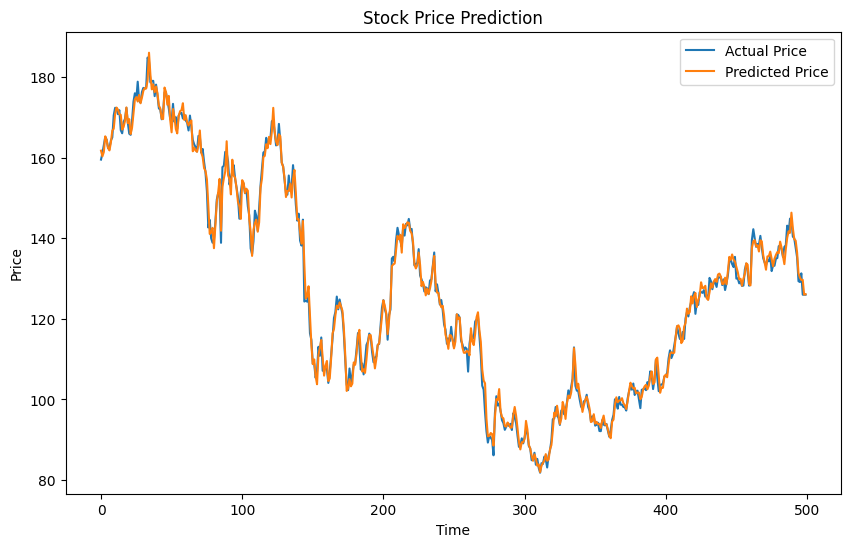

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
